In [2]:
import pandas as pd
import math
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
import seaborn as sns
import numpy as np
import scipy as sp
import os
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [3]:
impute = True

In [41]:
# df = pd.read_csv("../data/test.csv", parse_dates=['timestamp'],index_col="id")
raw_test = pd.read_csv("../data/test.csv", parse_dates=['timestamp'],index_col="id")
locales = pd.read_csv("../data/okurg.csv")

# top fields from Grant's xgb
fields = ['timestamp','kremlin_km','full_sq', 'life_sq', 'kitch_sq', 'floor', 'max_floor', 'build_year', 
          'num_room', 'state','material','sub_area']
df = raw_test.loc[:,fields]
df = pd.merge(df,locales, how="left", on="sub_area").reset_index(drop=True).set_index(df.index)

## Thoughts
* outliers?
    df[df.life_to_full<.25]
    

# Missingness Overview

In [42]:
print "shape of data {}".format(df.shape)
missing = df.isnull()
print "num cols missing {}".format(sum(missing.any(axis=0)))
print "num rows missing {}".format(sum(missing.any(axis=1)))
print "rows with missing {:.2f}%".format(100. * sum(missing.any(axis=1))/len(df))
print "\n"
cols = ['full_sq', 'life_sq', 'kitch_sq', 'floor', 'max_floor', 'build_year', 'num_room', 'state','sub_area']
for col in cols:
    print "number of missing {} {}".format(col,sum(df[col].isnull()))

shape of data (7662, 13)
num cols missing 3
num rows missing 1599
rows with missing 20.87%


number of missing full_sq 0
number of missing life_sq 1176
number of missing kitch_sq 0
number of missing floor 0
number of missing max_floor 0
number of missing build_year 1049
number of missing num_room 0
number of missing state 694
number of missing sub_area 0


### Helper Functions

In [43]:
def getKremlinGroup(df, id):
    """ returns the group that are the same distance from the kremlin"""
    x = df.loc[id,'kremlin_km']
    return df.loc[df.kremlin_km==x,:]
    

## Initial changes
Drop some initial outliers
    * full_sq < 10 set to nan
    * life > full both to nan
    * kitch > full both to nan
    * kitch > life both to nan
    * kitch > 200 to nan
    * floor == 0 to nan
    * max_floor == 0 to nan
    * max_floor < floor to nan
    * build_year 
        * 1500 < build_year > 2018 to nan
    * num_room == 0 to nan

    

In [44]:
def printStats(test):
    print "number that full_sq > 450 : ", len(test[test.full_sq > 450])
    print "number that full_sq < 10 : ", len(test[test.full_sq < 10])
    print "number that full < life : ", len(test[test.full_sq < test.life_sq])
    print "number that full < kitch : ", len(test[test.full_sq < test.kitch_sq])
    print "number that life < kitch : ", len(test[test.life_sq < test.kitch_sq])
    print "number that kitch > 200 : ", len(test[test.kitch_sq > 200])
    print "number that kitch <= 1 : ", len(test[test.kitch_sq <= 1])

    print "number that floor == 0 : ", len(test[test.floor == 0])
    print "number that floor > 70 : ", len(test[test.floor > 70])
    print "number that max_floor > 70 : ", len(test[test.max_floor > 70])
    print "number that max_floor == 0 : ", len(test[test.max_floor == 0])
    print "number that max_floor < floor : ", len(test[test.max_floor < test.floor])
    print "number that num_room == 0 : ", len(test[test.num_room == 0])
    print "number that build_year <=1  : ", len(test[test.build_year <= 1])

## Possible Wrong Values

In [45]:
ints = df[(df.full_sq * 10 % 10 == 0)].sort_values('full_sq',ascending=False)
floats = df[(df.full_sq * 10 % 10 != 0)].sort_values('full_sq',ascending=False)

print "How many have the full_sq as an integer e.g. 34.0 and not 34.1", len(ints)
print "How many have the full_sq as an floats ", len(floats)

How many have the full_sq as an integer e.g. 34.0 and not 34.1 713
How many have the full_sq as an floats  6949


In [46]:
rows = [35108,32505,30938,35857,36824]
print "before"
print df.loc[rows,['full_sq','life_sq']]
df.loc[35108,'full_sq'] = 40.3
df.loc[32505,'life_sq'] = 23.7
df.loc[30938,'full_sq'] = 37.80
df.loc[35857, 'full_sq'] = 76.04
df.loc[36824, 'full_sq'] = 64.00
print "after"
print df.loc[rows,['full_sq','life_sq']]

before
       full_sq  life_sq
id                     
35108    403.0     1.00
32505     40.2   237.00
30938      0.0    37.80
35857      1.0    42.07
36824      2.0     2.00
after
       full_sq  life_sq
id                     
35108    40.30     1.00
32505    40.20    23.70
30938    37.80    37.80
35857    76.04    42.07
36824    64.00     2.00


In [47]:
# life_off = [33265, 31075, 32370, 35661, 32505]

In [48]:
df = df.assign(room_size = lambda df: df.life_sq / df.num_room)

In [49]:
# look like the values are reverses
rows = [30593, 32501, 30645, 33278, 30538]
print "before"
print df.loc[rows,['full_sq','life_sq']]

new_full = df.loc[rows,"life_sq"].copy()
new_life = df.loc[rows,"full_sq"].copy()
df.loc[rows,"full_sq"] = new_full
df.loc[rows,"life_sq"] = new_life

print "after"
print df.loc[rows,['full_sq','life_sq']]

before
       full_sq  life_sq
id                     
30593   100.04   104.28
32501    51.90    93.20
30645    57.80    60.00
33278    14.80    33.80
30538    29.80    30.60
after
       full_sq  life_sq
id                     
30593   104.28   100.04
32501    93.20    51.90
30645    60.00    57.80
33278    33.80    14.80
30538    30.60    29.80


In [50]:
print "Test data stats"
printStats(df)

Test data stats
number that full_sq > 450 :  0
number that full_sq < 10 :  0
number that full < life :  4
number that full < kitch :  5
number that life < kitch :  13
number that kitch > 200 :  2
number that kitch <= 1 :  2128
number that floor == 0 :  0
number that floor > 70 :  0
number that max_floor > 70 :  0
number that max_floor == 0 :  233
number that max_floor < floor :  643
number that num_room == 0 :  0
number that build_year <=1  :  556


### Max vs Floor
floor > max_floor

Looks like the distribution of floors is off in the missing data. I think the columns are acutally switched.
Like the rows with messed up sq feet, there are a lot of 1s and 0s that come from the Novomoskovsky region.

I think the 0s and 1s are nan here too

left Floor distribution of questionable ones, floor>max and floor > 1
right floor distribution for floor < max and floor > 1


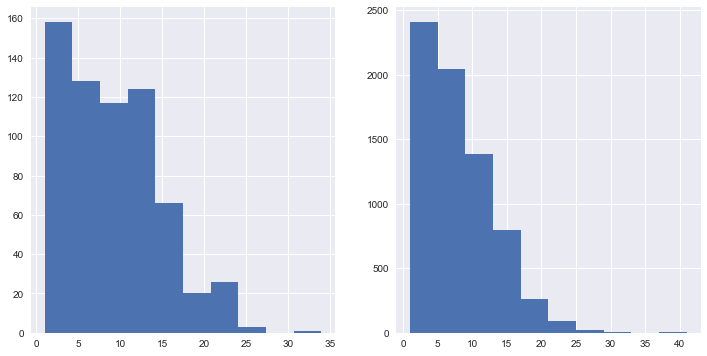

In [51]:
missing = df[(df.floor>df.max_floor)]
missing = missing.drop(['timestamp','sub_area','okurg_district'],axis=1)


fig, axs = plt.subplots(ncols = 2, figsize=(12,6))
missing.floor.hist(ax=axs[0])
print "left Floor distribution of questionable ones, floor>max and floor > 1"
print "right floor distribution for floor < max and floor > 1"

df[(df.max_floor>=df.floor)].floor.hist(ax=axs[1])

left: max_floor distribution of the questionable data, floor > max_floor 
right: max_floor distribution of good data, floor < max


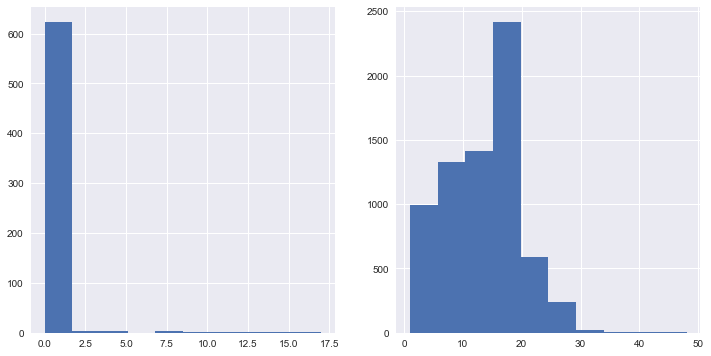

In [52]:
fig, axs = plt.subplots(ncols = 2, figsize=(12,6))
missing.max_floor.hist(ax=axs[0])
print "left: max_floor distribution of the questionable data, floor > max_floor "
print "right: max_floor distribution of good data, floor < max"
df[(df.max_floor>=df.floor)].max_floor.hist(ax=axs[1])

Again, the number of 0s are heavily in teh Novosmoky region

In [53]:
max_floor_0 = df[df.max_floor == 0].okurg_district.value_counts()
max_floor_1 = df[df.max_floor == 1].okurg_district.value_counts()
bad = pd.concat([max_floor_0.to_frame(),max_floor_1.to_frame()],axis=1)
bad.columns = ["max_floor_0","max_floor_1"]
bad.sort_values('max_floor_0',ascending=False)

,max_floor_0,max_floor_1
Novomoskovsky,160,112
Southern,24,18
South Eastern,9,4
Western,9,45
Central,8,99
North Eastern,6,48
Northern,4,10
South Western,3,5
Troitsky,3,9
Zelenograd,3,30


In [54]:
df[df.max_floor>1].max_floor.value_counts()

17    1827
9     1004
5      766
12     737
14     439
16     425
25     221
22     218
24     180
15     132
3      127
10     120
20     117
8      107
18      95
19      69
4       58
7       58
13      57
11      57
23      48
6       43
2       36
21      28
30      16
29       7
26       7
48       6
40       5
27       4
35       3
33       2
31       2
39       1
28       1
32       1
37       1
38       1
41       1
Name: max_floor, dtype: int64

In [55]:
df.loc[df.max_floor==0,'max_floor'] = np.nan

### floor > max_floor and max_floor > 1
I think these columns are mixed up because the floor is a freuqent max floor in the good columns

In [56]:
bad = df[(df.floor>df.max_floor) & (df.max_floor > 1)].copy()
bad

,timestamp,kremlin_km,full_sq,life_sq,kitch_sq,floor,max_floor,build_year,num_room,state,material,sub_area,okurg_district,room_size
id,,,,,,,,,,,,,,
30857,2015-07-30,28.738141,26.53,NaN,8.0,12,7.0,2015.0,1,1.0,6,Poselenie Filimonkovskoe,Novomoskovsky,NaN
31468,2015-09-05,2.359888,62.50,39.1,7.1,8,5.0,1950.0,3,2.0,2,Arbat,Central,13.033333
31804,2015-09-23,13.916494,31.40,18.7,5.8,5,3.0,1963.0,1,3.0,2,Losinoostrovskoe,North Eastern,18.700000
32018,2015-10-03,10.797261,57.00,41.9,5.4,9,5.0,1971.0,3,3.0,1,Ljublino,South Eastern,13.966667
32313,2015-10-21,22.837277,35.70,14.2,9.3,17,10.0,2002.0,1,3.0,1,Juzhnoe Butovo,South Western,14.200000
32944,2015-11-18,29.133765,59.80,59.8,1.0,20,15.0,2015.0,2,1.0,1,Poselenie Desjonovskoe,Novomoskovsky,29.900000
33213,2015-11-28,9.831830,32.80,20.4,5.4,5,3.0,1966.0,1,2.0,1,Perovo,Eastern,20.400000
33849,2015-12-21,13.415573,95.90,50.2,12.4,10,3.0,2006.0,3,3.0,1,Mozhajskoe,Western,16.733333
34164,2016-01-09,28.151572,37.70,37.7,1.0,25,10.0,2016.0,1,1.0,1,Poselenie Shherbinka,Novomoskovsky,37.700000


In [57]:
new_max = bad.floor.copy()
new_floor = bad.max_floor.copy()
df.loc[bad.index,'max_floor'] = new_max
df.loc[bad.index,'floor'] = new_floor
df.loc[bad.index,:]

,timestamp,kremlin_km,full_sq,life_sq,kitch_sq,floor,max_floor,build_year,num_room,state,material,sub_area,okurg_district,room_size
id,,,,,,,,,,,,,,
30857,2015-07-30,28.738141,26.53,NaN,8.0,7.0,12.0,2015.0,1,1.0,6,Poselenie Filimonkovskoe,Novomoskovsky,NaN
31468,2015-09-05,2.359888,62.50,39.1,7.1,5.0,8.0,1950.0,3,2.0,2,Arbat,Central,13.033333
31804,2015-09-23,13.916494,31.40,18.7,5.8,3.0,5.0,1963.0,1,3.0,2,Losinoostrovskoe,North Eastern,18.700000
32018,2015-10-03,10.797261,57.00,41.9,5.4,5.0,9.0,1971.0,3,3.0,1,Ljublino,South Eastern,13.966667
32313,2015-10-21,22.837277,35.70,14.2,9.3,10.0,17.0,2002.0,1,3.0,1,Juzhnoe Butovo,South Western,14.200000
32944,2015-11-18,29.133765,59.80,59.8,1.0,15.0,20.0,2015.0,2,1.0,1,Poselenie Desjonovskoe,Novomoskovsky,29.900000
33213,2015-11-28,9.831830,32.80,20.4,5.4,3.0,5.0,1966.0,1,2.0,1,Perovo,Eastern,20.400000
33849,2015-12-21,13.415573,95.90,50.2,12.4,3.0,10.0,2006.0,3,3.0,1,Mozhajskoe,Western,16.733333
34164,2016-01-09,28.151572,37.70,37.7,1.0,10.0,25.0,2016.0,1,1.0,1,Poselenie Shherbinka,Novomoskovsky,37.700000


In [58]:
krems = df[df.floor<df.max_floor].kremlin_km.unique()
kremGroups = df[df.floor<df.max_floor].groupby('kremlin_km').max_floor.value_counts(normalize=True)
kg_dict = {x:{} for x in krems}


In [59]:
for x in kremGroups.iteritems():
    km = x[0][0]
    floor = x[0][1]
    ratio = x[1]
    kg_dict[km][floor] = ratio 

In [60]:
bad_floors = df[df.floor>df.max_floor]

def getMaxFloorCounts(kremlin_km,floor):
    x = kg_dict.get(kremlin_km,None)
    if x:
        return x.get(floor,np.nan)
    else:
        return np.nan

In [61]:
bad_floors['floor_freq_in_max'] = bad_floors.apply(lambda x: getMaxFloorCounts(x['kremlin_km'],x['floor']),axis=1)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [62]:
bad_floors = df[df.floor>df.max_floor].floor.value_counts().to_frame()
good_floors = raw_test[raw_test.floor<raw_test.max_floor].floor.value_counts(normalize=True).to_frame()

In [63]:
floors = pd.concat([bad_floors,good_floors],axis=1)
floors.columns = ['bad_floor_counts','frequencey_in_good_data']
floors.sort_values('bad_floor_counts',ascending=False)

,bad_floor_counts,frequencey_in_good_data
3.0,34.0,0.101262
4.0,30.0,0.095115
7.0,29.0,0.072145
2.0,27.0,0.105629
8.0,27.0,0.076027
9.0,26.0,0.049499
14.0,25.0,0.029602
6.0,25.0,0.072145
5.0,25.0,0.071821
11.0,23.0,0.049175


So it looks like the higher ones are definitely off, the problem is with the ones less than 5. <br>
Let's look at the distribution before and after reversing the columns

left is good data before the flip and right is after the flip, not real change


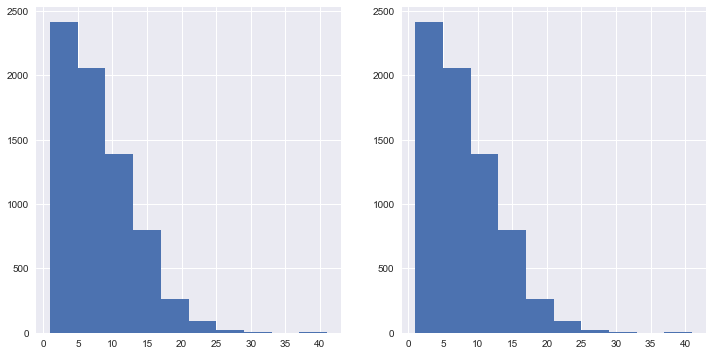

In [64]:
fig, axs = plt.subplots(ncols = 2, figsize=(12,6))
df[df.floor<=df.max_floor].floor.hist(ax=axs[0])
print "left is good data before the flip and right is after the flip, not real change"
temp = df.copy()
bad_index = temp[(temp.floor>temp.max_floor) & (temp.max_floor != 0)].index
new_floor = temp.loc[bad_index,'max_floor'].tolist()
new_max = temp.loc[bad_index,'floor'].tolist()
temp.loc[bad_index,'floor'] = new_floor
temp.loc[bad_index,'max_floor']= new_max

# distribution stays about the same after making this adjustment
temp[df.floor<=df.max_floor].floor.hist(ax=axs[1])

In [65]:
if impute:
    bad_floors = df[df.floor>df.max_floor].copy()
    indx = bad_floors.index

    # switching the floor columns 
    new_floor = df.loc[indx,'max_floor']
    new_max = df.loc[indx,'floor']
    
    bad_floors.loc[indx,'max_floor'] = new_max
    bad_floors.loc[indx, 'floor'] = new_floor
    df.loc[bad_floors.index,:] = bad_floors

else:
    bad_floors.loc[:,'max_floor'] = np.nan
# bad_floors.sort_values('max_floor')

# Imputing Missing Floors

### KNN Regression first

Want to give more weight to neighborhood, so adding another kremlin variable

In [66]:
cols = ['kremlin_km', 'full_sq', 'floor', 'max_floor']

complete = df.loc[~df[cols].isnull().any(axis=1),cols].copy()
complete['kremlin_km2'] = complete['kremlin_km']

missing = df.loc[df.max_floor.isnull(),cols].copy()
missing['kremlin_km2'] = missing['kremlin_km']
cols = ['kremlin_km', 'full_sq', 'floor','kremlin_km2']

missing = missing.loc[~missing[cols].isnull().any(axis=1),:]
prediction_inputs = missing.drop('max_floor',axis=1).copy()

In [67]:
predictGroups = prediction_inputs.groupby('floor')

In [68]:
for p in predictGroups:
    c = complete[complete.max_floor > p[0]]
    n = len(c)
        
    neigh = KNeighborsRegressor(n_neighbors=min(2,n))
    missing.loc[p[1].index,'max_floor_KNNR2'] = neigh.fit(c.drop('max_floor',axis=1),
                                          c.max_floor).predict(p[1])

    neigh = KNeighborsRegressor(n_neighbors=min(5,n))
    missing.loc[p[1].index,'max_floor_KNNR5'] = neigh.fit(c.drop('max_floor',axis=1),
                                          c.max_floor).predict(p[1])

    neigh = KNeighborsRegressor(n_neighbors=min(100,n))
    missing.loc[p[1].index,'max_floor_KNNR100'] = neigh.fit(c.drop('max_floor',axis=1),
                                          c.max_floor).predict(p[1])

### Trying KNN with everything as a category

Set all columns to category because I wanted to find try and match up the exact building from the group. Rounded the sq meters to the closest 5 to improve the odds of matching.

In [69]:
def roundIt(x, base=5):
    return int(base * round(float(x)/base))

In [70]:
cols = ['kremlin_km', 'full_sq', 'floor','kremlin_km2']

# make the sq round so it's easier to match 
missing['full_sq'] = missing['full_sq'].apply(roundIt)

## drop all rows with missing in anything except max_floor
prediction_inputs = missing[cols].apply(lambda x: x.astype('category'),axis=0)

predictGroups = prediction_inputs.groupby('floor')

for p in predictGroups:
    c = complete[complete.max_floor > p[0]]
    n = len(c)

    neigh = KNeighborsClassifier(n_neighbors=min(2,n))
    missing.loc[p[1].index,'max_floor_KNNC2'] = neigh.fit(c.drop('max_floor',axis=1),
                                          c.max_floor).predict(p[1])

    neigh = KNeighborsClassifier(n_neighbors=min(5,n))
    missing.loc[p[1].index,'max_floor_KNNC5'] = neigh.fit(c.drop('max_floor',axis=1),
                                          c.max_floor).predict(p[1])

    neigh = KNeighborsClassifier(n_neighbors=min(100,n))
    missing.loc[p[1].index,'max_floor_KNNC100'] = neigh.fit(c.drop('max_floor',axis=1),
                                          c.max_floor).predict(p[1])



## Selecting Max_floor
Selected the max floor based on the mode from all of the KNN observations

In [71]:
missing = missing.apply(pd.to_numeric)
for col in missing.columns[6:12]:
    missing.loc[missing[col] < missing.floor, col] = np.nan

In [72]:
missing.max_floor = missing.iloc[:,6:12].mode(axis=1,numeric_only=True)

In [73]:
if impute:
    df.loc[missing.index,'max_floor'] = missing.max_floor

In [74]:
df.head()

,timestamp,kremlin_km,full_sq,life_sq,kitch_sq,floor,max_floor,build_year,num_room,state,material,sub_area,okurg_district,room_size
id,,,,,,,,,,,,,,
30474,2015-07-01,24.779082,39.0,20.7,8.9,2.0,9.0,1998.0,1,3.0,1,Juzhnoe Butovo,South Western,20.70
30475,2015-07-01,21.722620,79.2,NaN,1.0,8.0,17.0,0.0,3,1.0,1,Poselenie Vnukovskoe,Novomoskovsky,NaN
30476,2015-07-01,10.320728,40.5,25.1,4.8,3.0,5.0,1960.0,2,2.0,2,Perovo,Eastern,12.55
30477,2015-07-01,26.960463,62.8,36.0,62.8,17.0,17.0,2016.0,2,3.0,1,Poselenie Voskresenskoe,Novomoskovsky,18.00
30478,2015-07-01,21.905792,40.0,40.0,1.0,17.0,17.0,0.0,1,1.0,1,Poselenie Vnukovskoe,Novomoskovsky,40.00


In [75]:
cols = ['full_sq','floor','max_floor']
# df.sort_values('full_sq',ascending=False)
df.drop('room_size',axis=1).to_csv('../data/clean_test_chase.csv')

# STOP HERE
old below


## Missing SQ

In [152]:
print "num missing life_sq", sum(df.life_sq.isnull())
print "num missing kitch_sq", sum(df.kitch_sq.isnull())

num missing life_sq 6781
num missing kitch_sq 15753


In [153]:
df = df.assign(life_to_full = lambda df: df.life_sq / df.full_sq)
df = df.assign(kitch_to_life = lambda df: df.kitch_sq / df.life_sq)

In [154]:
missing = df[df.life_sq.isnull() | df.kitch_sq.isnull()].copy()
df = df.assign(diff_full_life = lambda df: df.full_sq - df.life_sq)
df.loc[df.life_to_full<.15,['full_sq','life_sq','kitch_sq']] = np.nan 
bad = df[df[['full_sq','life_sq','kitch_sq']].isnull().all(axis=1)].index
df.drop(bad,axis=0,inplace=True)

### Will use median of the dist group ratios to impute missingness
first life_sq

In [162]:
print sum(raw_train.kitch_sq.isnull())
print sum(raw_train.kitch_sq<=1)

9572
6235


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10bc93210>]], dtype=object)

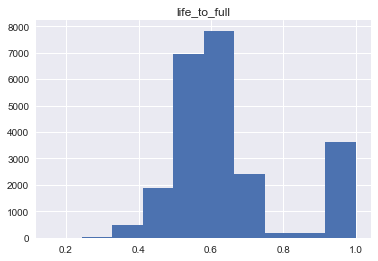

In [163]:
# most of the aparts have a life to full ratio of 60%
df[df.life_sq>0].hist('life_to_full')

In [164]:
test.loc[test.full_sq == 0,'full_sq'] = np.nan
test.loc[test.full_sq<test.life_sq,'full_sq'] = np.nan
test = test.assign(life_to_full = lambda df: df.life_sq / df.full_sq)
test = test.assign(kitch_to_life = lambda df: df.kitch_sq / df.life_sq)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10bcafdd0>]], dtype=object)

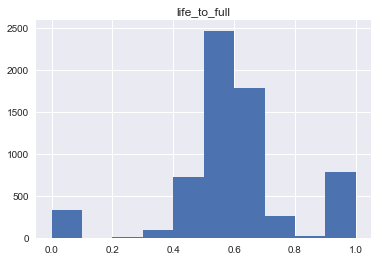

In [165]:
# Similiar to the uncleaned test datat
test.hist('life_to_full')

In [166]:
cols = ['price_doc','kremlin_km', 'full_sq','life_sq','life_to_full','floor', 'sub_area']
complete = df.loc[~df[cols].isnull().any(axis=1),cols].copy()

missingGroupsKrem = missing.groupby('kremlin_km')
missingGroupsSubArea = missing.groupby('sub_area')
for g in missingGroupsKrem:
    c = complete[complete.kremlin_km == g[0]]
    if len(c) < 1:
        c = complete[complete.sub_area == g[1].sub_area.unique().tolist()[0]]
    ratio = np.nanmedian(c.life_to_full)
    missing.loc[g[1].index,'life_sq'] = g[1].full_sq * ratio

### Kitch_sq
going to do the same for kitch_sq 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x112058cd0>]], dtype=object)

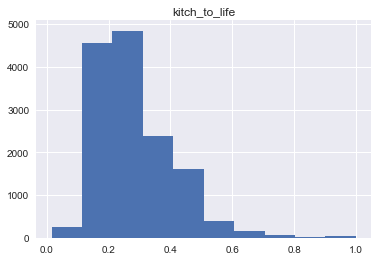

In [167]:
df[df.kitch_sq>0].hist('kitch_to_life')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1121268d0>]], dtype=object)

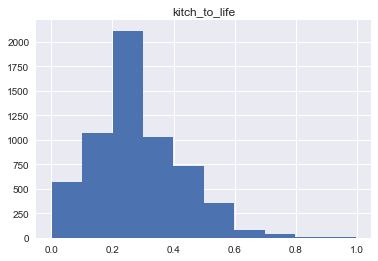

In [168]:
# distribution is about 20-30%
test[(test.kitch_to_life>0) & (test.kitch_to_life<1)].hist('kitch_to_life')

In [169]:
cols = ['price_doc','kremlin_km','life_sq','kitch_sq','kitch_to_life','floor', 'sub_area']
complete = df.loc[~df[cols].isnull().any(axis=1),cols].copy()

missingGroupsKrem = missing.groupby('kremlin_km')
missingGroupsSubArea = missing.groupby('sub_area')
for g in missingGroupsKrem:
    c = complete[complete.kremlin_km == g[0]]
    if len(c) < 1:
        c = complete[complete.sub_area == g[1].sub_area.unique().tolist()[0]]
    ratio = np.nanmedian(c.kitch_to_life)
    missing.loc[g[1].index,'kitch_sq'] = g[1].life_sq * ratio

In [170]:
df.drop(df[df.full_sq.isnull()].index,axis=0,inplace=True)

df.drop(df[df.kitch_sq.isnull()].index, axis=0,inplace=True)


df.drop(df[df.floor.isnull()].index, axis=0,inplace=True)
df.drop(df[df.max_floor.isnull()].index, axis=0,inplace=True)
df.drop('diff_full_life', axis=1).to_csv('../input/trainCleanSQFL.csv')

# Missing Build Year

In [171]:
add_multiples(df)

In [172]:
df['quarter'] = pd.PeriodIndex(df['timestamp'], freq='Q').strftime('Q%q-%y')

In [173]:
dfg = df.loc[:,['quarter','okurg_district','price_full']].groupby('okurg_district')

In [174]:
md = dfg.aggregate(np.nanmedian)

In [175]:
x = np.log(df.price_doc)
y = np.log(df.price_doc + 1)

In [176]:
print(x[0:10])
print(y[0:10])

id
7675    16.128046
8138    16.012735
8156    15.763069
8157    15.775605
8171    15.243067
8178    15.679591
8258    16.308716
8285    15.856731
8290    16.275099
8296    14.285514
Name: price_doc, dtype: float64
id
7675    16.128046
8138    16.012735
8156    15.763069
8157    15.775605
8171    15.243067
8178    15.679591
8258    16.308716
8285    15.856731
8290    16.275099
8296    14.285515
Name: price_doc, dtype: float64


In [229]:
add_multiples(df)

In [231]:
df.sort_values('price_full_std',ascending=False).head()

,timestamp,price_doc,kremlin_km,full_sq,life_sq,kitch_sq,floor,max_floor,build_year,num_room,state,price_full_std
id,,,,,,,,,,,,
1,2011-08-20,5850000,15.156211,43,27.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN
2,2011-08-23,6000000,8.698054,34,19.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN
3,2011-08-27,5700000,9.067885,43,29.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN
4,2011-09-01,13100000,19.487005,89,50.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN
5,2011-09-05,16331452,2.578671,77,77.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN


In [238]:
# looks like a price outlier $3.7m for a 500 sq ft apt
df.drop(2121,axis=0,inplace=True)
dropped.append(2121)
# update price
# add_multiples(df)

In [178]:
bad_sq = df.query('full_sq < life_sq or life_sq < kitch_sq or full_sq.isnull()')

In [929]:
# change all full and life <= 10 to NaN
df.loc[df.full_sq < 10,'full_sq'] = np.nan
df.loc[df.life_sq < 10,['life_sq','kitch_sq']] = np.nan

df.loc[(df.kitch_sq >= df.life_sq), 'kitch_sq'] = np.nan
df.loc[(df.kitch_sq >= df.full_sq),'kitch_sq'] = np.nan

In [930]:
# remove the rows that don't have either full_sq or life_sq
bad = df[(df.full_sq.isnull())& (df.life_sq.isnull())]
df.drop(bad.index, axis=0, inplace=True)

dropped.extend(bad.index)


### Square Meter (full_sq, life_sq, kitch_sq)

Added price to square meters columns to help identify outliers
#### Adjustments
    * full and life < 10 are set to np.nan (10 is about a 100 sq foot apt)
    * full < life check to see which one appears to be the incorrect value based on price multiples stds.

kitchens with 0 or 1 maybe studio apts

In [931]:
df.sort_values('full_sq', ascending=False).head()

,price_doc,kremlin_km,full_sq,life_sq,kitch_sq,floor,max_floor,build_year,num_room,state,kindergarten_km,green_zone_km,school_km,material,metro_min_avto,public_healthcare_km,sub_area,industrial_km,metro_min_walk,public_transport_station_km,railroad_km,swim_pool_km,timestamp,okurg_district,price_to_full,price_to_life,price_to_full_std,price_to_life_std,life_to_full,kitch_to_life
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3530,6868818,16.139809,5326.0,22.0,NaN,13.0,NaN,NaN,NaN,NaN,0.780191,0.499398,0.699257,NaN,4.907833,2.149384,Birjulevo Vostochnoe,0.214503,28.439791,0.228109,0.841827,3.381655,2012-09-07,Southern,1289.676680,312219.000000,NaN,NaN,0.004131,NaN
2783,13250000,12.307897,729.0,44.0,NaN,12.0,NaN,NaN,NaN,NaN,0.136485,0.023740,0.426871,NaN,2.685885,0.564859,Troparevo-Nikulino,1.415226,22.127146,0.119978,1.383085,2.488351,2012-07-06,Western,18175.582990,301136.363636,NaN,NaN,0.060357,NaN
22788,4725142,0.072897,637.0,637.0,10.0,18.0,19.0,2016.0,2.0,1.0,1.048962,0.189089,0.269716,4.0,1.482746,2.608162,Tverskoe,2.640803,13.459068,0.326035,2.566044,1.421099,2014-09-23,Central,7417.805338,7417.805338,NaN,NaN,1.000000,0.015699
18344,6213200,20.549464,634.0,NaN,0.0,3.0,17.0,NaN,2.0,NaN,0.286711,0.017572,0.214197,1.0,4.721045,5.422551,Nekrasovka,0.394108,45.322032,0.035986,1.214861,8.106936,2014-05-13,South Eastern,9800.000000,NaN,NaN,NaN,NaN,NaN
5947,10200000,16.292579,634.0,38.0,NaN,3.0,NaN,NaN,NaN,NaN,0.025172,0.121641,0.353390,NaN,1.746993,1.566321,Lianozovo,1.063524,8.067791,0.204624,1.426593,2.029415,2013-02-07,North Eastern,16088.328076,268421.052632,NaN,NaN,0.059937,NaN


In [932]:
# changed the max to 53
df.loc[3530,'full_sq'] = 53

In [934]:
df.sort_values('price_to_full',ascending=False).head()

,price_doc,kremlin_km,full_sq,life_sq,kitch_sq,floor,max_floor,build_year,num_room,state,kindergarten_km,green_zone_km,school_km,material,metro_min_avto,public_healthcare_km,sub_area,industrial_km,metro_min_walk,public_transport_station_km,railroad_km,swim_pool_km,timestamp,okurg_district,price_to_full,price_to_life,price_to_full_std,price_to_life_std,life_to_full,kitch_to_life
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
16102,65000000,3.328401,120.0,63.0,17.0,15.0,20.0,2002.0,3.0,4.0,0.367275,0.038431,0.438905,4.0,1.365098,0.951508,Hamovniki,1.450669,4.670340,0.156870,1.032216,1.398559,2014-03-17,Central,541666.666667,1.031746e+06,7.441133,7.064074,0.525000,0.269841
11088,71200000,10.685592,132.0,76.0,12.0,16.0,28.0,2006.0,4.0,NaN,0.482608,0.300011,0.307083,4.0,2.474512,1.186187,Prospekt Vernadskogo,2.282690,15.060547,0.250839,2.005483,0.452202,2013-10-08,Western,539393.939394,9.368421e+05,7.399770,6.225587,0.575758,0.157895
24859,53787140,4.190635,101.0,NaN,0.0,15.0,0.0,NaN,2.0,NaN,0.151933,0.123367,0.495513,4.0,1.498269,2.091276,Donskoe,1.216591,11.697905,0.038747,1.215073,1.336556,2014-11-18,Southern,532545.940594,NaN,7.275139,NaN,NaN,NaN
7460,91066096,7.424229,185.0,66.0,NaN,33.0,NaN,NaN,NaN,NaN,0.543921,0.123274,0.883583,NaN,3.721862,1.491677,Ramenki,0.858441,30.224681,0.379486,0.920536,0.485134,2013-04-19,Western,492249.167568,1.379789e+06,6.541751,10.139075,0.356757,NaN
3560,77000000,3.477546,157.0,89.0,NaN,15.0,NaN,NaN,NaN,NaN,0.191674,0.344225,1.072453,NaN,1.244796,1.189904,Mar'ina Roshha,0.529682,11.417722,0.234259,1.220031,1.023092,2012-09-10,North Eastern,490445.859873,8.651685e+05,6.508932,5.592343,0.566879,NaN


#### Checking life_sq for possible wrong inputs

In [935]:
off = df[df.full_sq < df.life_sq].sort_values('life_sq', ascending=False)[0:15]
# off

In [936]:
# these appear to be off a digit 
off_index = off[0:13].index
if impute:
    df.loc[13549,'life_sq'] = df.loc[13549,'life_sq'] / 10 # off two digits
    df.loc[off_index,'life_sq'] = df.loc[off_index,'life_sq']/10
else:
    df.loc[off_index,'life_sq'] = np.nan

In [937]:
# df.loc[off.index,:]

### Full vs Life
when full < life, take the one that seems like less of an outlier 

In [938]:
bad_df = df[df.full_sq < df.life_sq]
print "number of rows " , len(bad_df)
bad_df.head()

number of rows  17


,price_doc,kremlin_km,full_sq,life_sq,kitch_sq,floor,max_floor,build_year,num_room,state,kindergarten_km,green_zone_km,school_km,material,metro_min_avto,public_healthcare_km,sub_area,industrial_km,metro_min_walk,public_transport_station_km,railroad_km,swim_pool_km,timestamp,okurg_district,price_to_full,price_to_life,price_to_full_std,price_to_life_std,life_to_full,kitch_to_life
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1825,5200000,13.635361,18.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,0.228476,0.075926,0.313596,NaN,2.334253,1.624978,Ljublino,1.083078,21.636236,0.103915,2.416847,3.217099,2012-04-09,South Eastern,288888.888889,136842.105263,2.840665,-0.842502,NaN,NaN
6534,13801229,13.143751,80.0,88.0,NaN,9.0,NaN,NaN,NaN,NaN,1.424717,0.646005,0.510474,NaN,3.405352,0.742342,Pokrovskoe Streshnevo,0.443602,27.479760,0.110209,0.713374,3.781754,2013-03-15,North Western,172515.362500,156832.147727,0.722707,-0.665888,NaN,NaN
6996,6290256,20.549464,73.0,77.0,NaN,10.0,NaN,NaN,NaN,NaN,0.286711,0.017572,0.214197,NaN,4.721045,5.422551,Nekrasovka,0.394108,45.322032,0.035986,1.214861,8.106936,2013-04-03,South Eastern,86167.890411,81691.636364,-0.848787,-1.329762,NaN,NaN
8104,3622465,20.549464,37.0,38.0,NaN,8.0,NaN,NaN,NaN,NaN,0.286711,0.017572,0.214197,NaN,4.721045,5.422551,Nekrasovka,0.394108,45.322032,0.035986,1.214861,8.106936,2013-05-23,South Eastern,97904.459459,95328.026316,-0.635186,-1.209283,NaN,NaN
9485,3000000,13.687390,52.0,53.0,8.0,12.0,1.0,1983.0,2.0,3.0,0.194483,0.030993,0.298627,1.0,3.198813,2.625650,Juzhnoe Medvedkovo,0.484628,25.427899,0.137156,0.659250,5.202360,2013-07-27,North Eastern,57692.307692,56603.773585,-1.367033,-1.551417,NaN,0.150943


In [939]:
sum(df.full_sq.isnull())

7

## Life_sq > Full_sq???
select the one that seems like the least of an outlier based on price to sq

In [940]:
# select full and np.nan life if price to full is more reasonable
full_ind = bad_df[abs(bad_df.price_to_full_std) < abs(bad_df.price_to_life_std)].index

# select life and np.nan full if price to full is more reasonable
life_ind = [x for x in bad_df.index if x not in full_ind]

df.loc[full_ind, 'life_sq'] = np.nan
df.loc[life_ind, 'full_sq'] = np.nan


# updating multiples
add_multiples(df)

In [941]:
# df[df.life_sq.isnull()]

#### Characteristics by Neighborhood
Grouped the data by subset and will take the median neighborhood ratios of sq meters to impute missingness

In [942]:
df.loc[[27398,30446],:]

,price_doc,kremlin_km,full_sq,life_sq,kitch_sq,floor,max_floor,build_year,num_room,state,kindergarten_km,green_zone_km,school_km,material,metro_min_avto,public_healthcare_km,sub_area,industrial_km,metro_min_walk,public_transport_station_km,railroad_km,swim_pool_km,timestamp,okurg_district,price_to_full,price_to_life,price_to_full_std,price_to_life_std,life_to_full,kitch_to_life
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
27398,6489774,16.957155,62.0,NaN,NaN,13.0,17.0,NaN,2.0,1.0,0.230087,0.360319,0.044599,1.0,3.343157,1.242741,Solncevo,0.631064,24.450869,0.257288,0.874445,2.128289,2015-01-21,Western,104673.774194,NaN,-0.511887,NaN,NaN,NaN
30446,7567425,16.957155,79.0,NaN,NaN,17.0,17.0,NaN,3.0,1.0,0.230087,0.360319,0.044599,1.0,3.343157,1.242741,Solncevo,0.631064,24.450869,0.257288,0.874445,2.128289,2015-06-27,Western,95790.189873,NaN,-0.673618,NaN,NaN,NaN


In [943]:
dfg = df.groupby('sub_area')
life_full_dict = dfg['life_to_full'].aggregate('median').to_dict()
kitch_life_dict = dfg['kitch_to_life'].aggregate('median').to_dict()

In [944]:
# impute the missing sq by using the sub areas 

mis_full_index = df[df.full_sq.isnull()].index
mis_life_index = df[df.life_sq.isnull()].index
mis_kitch_index = df[df.kitch_sq.isnull() | (df.kitch_sq > df.life_sq)].index

if impute:
    # update the life_to_full ratio from median of subareas
    df.loc[mis_full_index,'life_to_full'] = [life_full_dict[x] for x in df.loc[mis_full_index,'sub_area']]
    df.loc[mis_life_index,'life_to_full'] = [life_full_dict[x] for x in df.loc[mis_life_index,'sub_area']]
    df.loc[mis_kitch_index,'kitch_to_life'] = [kitch_life_dict[x] for x in df.loc[mis_kitch_index,'sub_area']]
    
    # impute sq based off of ratio
    df.loc[mis_full_index,:] = df.loc[mis_full_index,:].assign(full_sq = lambda x: x.life_sq / x.life_to_full)
    df.loc[mis_life_index,:] = df.loc[mis_life_index,:].assign(life_sq = lambda x: x.full_sq * x.life_to_full)
    df.loc[mis_kitch_index,:] = df.loc[mis_kitch_index,:].assign(kitch_sq = lambda x: x.life_sq * x.kitch_to_life)

In [945]:
add_multiples(df)

### Building characteristics
Imputations: 
    Years = change every build year less than 1875 to 1875

In [947]:
if impute:
    df.loc[df.build_year < 1875, 'build_year'] = 1875
    df.loc[df.build_year==1, 'build_year'] = 2001
    df.loc[df.build_year==3, 'build_year'] = 2003
    df.loc[df.build_year==20, 'build_year'] = 2000
    df.loc[df.build_year==71, 'build_year'] = 1971
    df.loc[df.build_year==215, 'build_year'] = 2015
    df.loc[15223,'build_year'] = 1965
    df.loc[10092,'build_year'] = 2005
    df.loc[10093,'build_year'] = 2009

#### If max floor is nan
try a random sample from first the group by distance else the DF set

In [983]:
bad = df[df.max_floor.isnull()].index
if impute:
    df.loc[bad,"max_floor"] = [imputeMaxFloor(x) for x in bad]

In [989]:
np.random.randint(15)

8

In [991]:
bad = df[df.floor.isnull()].index
if impute:
    df.loc[bad,'floor'] = [np.random.randint(df.loc[x,'max_floor']) for x in bad]

### Looking at missing year
first see if it matches any other buildings by max_floor in the dist group

In [42]:
df.head()

,timestamp,price_doc,kremlin_km,full_sq,life_sq,kitch_sq,floor,max_floor,build_year,num_room,state,material,sub_area,okurg_district,life_to_full,kitch_to_life,diff_full_life
id,,,,,,,,,,,,,,,,,
1,2011-08-20,5850000,15.156211,43.0,27.0,NaN,4.0,5.0,NaN,NaN,NaN,NaN,Bibirevo,North Eastern,0.627907,NaN,16.0
2,2011-08-23,6000000,8.698054,34.0,19.0,NaN,3.0,9.0,NaN,NaN,NaN,NaN,Nagatinskij Zaton,Southern,0.558824,NaN,15.0
3,2011-08-27,5700000,9.067885,43.0,29.0,NaN,2.0,5.0,NaN,NaN,NaN,NaN,Tekstil'shhiki,South Eastern,0.674419,NaN,14.0
4,2011-09-01,13100000,19.487005,89.0,50.0,NaN,9.0,17.0,NaN,NaN,NaN,NaN,Mitino,North Western,0.561798,NaN,39.0
5,2011-09-05,16331452,2.578671,77.0,77.0,NaN,4.0,8.0,NaN,NaN,NaN,NaN,Basmannoe,Central,1.000000,NaN,0.0


In [1219]:
ms_distances = missing.kremlin_km.unique()

In [1262]:
for d in ms_distances:
    c = complete[complete.kremlin_km == d]
    
    # check to make sure there are enough observations in the complete group, if not use total complete
    if len(c) < 3:
        c = complete
    m = missing[missing.kremlin_km == d]
    n = int(math.sqrt(len(c)))

    neigh = KNeighborsRegressor(n_neighbors=n)
    neigh.fit(c.drop('floor', axis=1),c.floor)
        
    missing.loc[m.index,'floor'] = neigh.predict(m.drop('floor', axis=1))


In [1266]:
if impute:
    df.loc[missing.index,'floor'] = missing.floor